# Data import for given station and given time period. Import also allows for parameter selection in output file.

In [2]:
from viresclient import SwarmRequest
import hapiclient
from hapiclient.util import pythonshell
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from chaosmagpy import load_CHAOS_matfile
from chaosmagpy.model_utils import synth_values
from chaosmagpy.data_utils import mjd2000 # Modified Julian date

import utils

The objective of this notebook is to download the full input data for a period of time and a given station. This notebook then exports the data to a csv file.

In [8]:
###Define station and time parameters, and OMNI parameters.

### Time parameters
start_date= 1998
end_date=2020

### Observatory parameters
observatory='LER' 

### Download observatory metadata:
obsmeta = utils.fetch_ground_obs(observatory,'1998-01-01','1998-01-03')
latitude = obsmeta.attrs['Latitude_GEO']
longitude_deg = obsmeta.attrs['Longitude_GEO']
radius = obsmeta.attrs['Radius_GEO']


###OPTIONAL: input radius, latitude,longitude manually
#latitude=55.31
#longitude_deg=356.79 ##longitude is in degrees from Prime Meridian, i.e. 1 degree west is 359 degrees
#radius= 6371


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.166MB)

In [9]:
###Step 1; Get year data into correct time indexing format


start_date_str= f'{start_date}-01-01'
end_date_str=f'{end_date}-01-01'

year_range=pd.date_range(start_date_str, end_date_str, freq='1YS')

print('list of years to be downloaded:')
print(year_range)

list of years to be downloaded:
DatetimeIndex(['1998-01-01', '1999-01-01', '2000-01-01', '2001-01-01',
               '2002-01-01', '2003-01-01', '2004-01-01', '2005-01-01',
               '2006-01-01', '2007-01-01', '2008-01-01', '2009-01-01',
               '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01',
               '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01',
               '2018-01-01', '2019-01-01', '2020-01-01'],
              dtype='datetime64[ns]', freq='YS-JAN')


In [10]:
###Step 2; Download magnetic field model for given station.


CHAOS7 = utils.loadChaosModel8(start_date,end_date,latitude,longitude_deg)
CHAOS7

###NOTE: This function assumes constant radius, which is not the case; radius varies according to latitude and height
###from sea level. Change radius= parameter (last parameter in function) to get more accurate.

###Further NOTE: this function does not include the last 24 hours of the period in question. Consider
###changing this if possible.

,B_radius,B_phi,B_theta,B_H
1998-01-01 00:00:00,-47935.869306,-1537.382106,-14810.179214,14889.759974
1998-01-01 00:01:00,-47935.869361,-1537.382008,-14810.179229,14889.759979
1998-01-01 00:02:00,-47935.869417,-1537.381910,-14810.179244,14889.759985
1998-01-01 00:03:00,-47935.869472,-1537.381812,-14810.179259,14889.759990
1998-01-01 00:04:00,-47935.869528,-1537.381714,-14810.179275,14889.759995
...,...,...,...,...
2020-12-30 23:56:00,-48597.544692,-327.077275,-15025.970872,15029.530271
2020-12-30 23:57:00,-48597.544692,-327.077275,-15025.970872,15029.530271
2020-12-30 23:58:00,-48597.544692,-327.077275,-15025.970872,15029.530271
2020-12-30 23:59:00,-48597.544692,-327.077275,-15025.970872,15029.530271


In [11]:
###Step 3; loop over years and download observatory data
    
    
##Define start and end of download period for this year
start= start_date_str
end= end_date_str

print('Downloading Observatory data for',observatory,str(start)[:4],'to',str(end)[:4])

obs = utils.fetch_ground_obs(observatory, start, end)#Download obs data
obs = utils.manipulate_obs_data(obs,CHAOS7)#Manipulate obs data to remove background mag field


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



          |  [ Elapsed: 00:00, Remaining: ?]  

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (242.635MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [2/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (242.635MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [3/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (164.508MB)

Manipulating obsvervatory data


<xarray.Dataset> Size: 682MB
Dimensions:    (Timestamp: 14199840)
Coordinates:
  * Timestamp  (Timestamp) datetime64[ns] 114MB 1998-01-01 ... 2024-12-31T23:...
Data variables:
    B_N        (Timestamp) float64 114MB 1.19 0.8893 0.6893 ... -84.31 -82.04
    B_E        (Timestamp) float64 114MB -36.22 -36.25 -36.27 ... 234.3 236.3
    B_C        (Timestamp) float64 114MB 13.26 13.56 13.56 ... -111.9 -108.9
    B_H        (Timestamp) float64 114MB -8.079 -8.382 -8.583 ... -76.08 -73.79
    dBdt       (Timestamp) float64 114MB nan -0.3024 -0.201 ... -1.5 2.291
Attributes:
    Sources:         ['SW_OPER_AUX_OBSM2__19980101T000000_19980101T235959_010...
    MagneticModels:  []
    AppliedFilters:  []
    Latitude_GEO:    59.93341164979802
    Longitude_GEO:   358.8
    Radius_GEO:      6362184.563545696


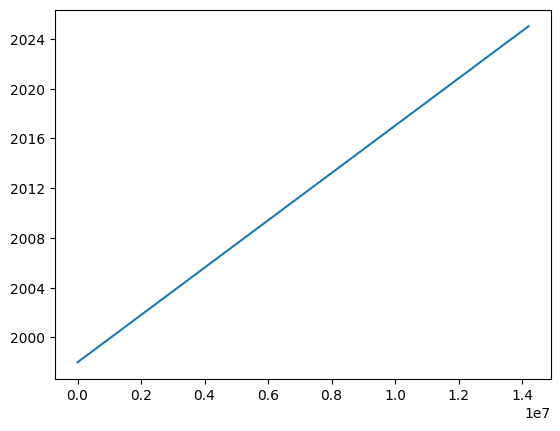

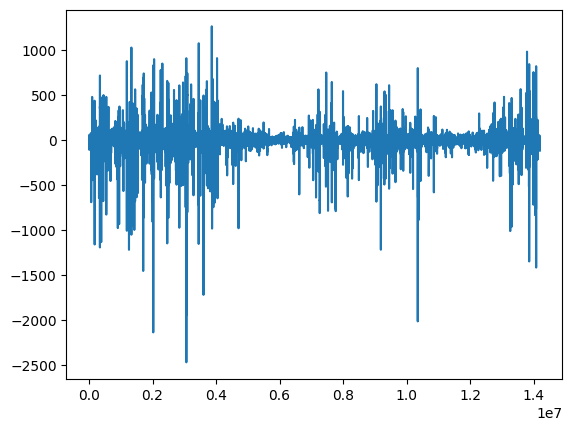

In [7]:
#print(events_tot['B_N'])

print(obs)

plt.plot(obs['Timestamp'])
plt.show()
plt.plot(obs['B_N'])
plt.show()

In [7]:
###Step 4: get current directory and set PATH variable to where data will be saved.

import os

# Get the current working directory
current_path = os.getcwd()

# Print the current working directory
print("Current working directory:", current_path)

#define path to data folder where data will be placed. Print current path if you don't know what it is!
PATH = '/mnt/c/users/s1725621/Documents/PhDCode/Git/CrossformerTimeSeries/Data/'

Current working directory: /mnt/c/users/s1725621/Documents/PhDCode/Git/CrossformerTimeSeries/Data


In [8]:
###Step 5: save observatory data.

###Save to netcdf file
##obs.to_netcdf(path = PATH+observatory+str(start)[:4]+str(end)[:4]+'.nc')

###Save to csv file
# Convert xarray Dataset to pandas DataFrame
obf = obs.to_dataframe()

# Save the DataFrame to a CSV file
obf.to_csv(PATH+observatory+str(start)[:4]+str(end)[:4]+'.csv',index=True)